## Importing Data

In [1]:
import sys
import time
import csv

import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import lightgbm as lgb
import catboost as ct
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV,KFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [2]:
path = 'kaggle/input/icr-identify-age-related-conditions/greeks.csv'
greeks_csv = pd.read_csv(path)
greeks_csv.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [3]:
print(greeks_csv.shape)

(617, 6)


In [4]:
path = 'kaggle/input/icr-identify-age-related-conditions/train.csv'
train_csv = pd.read_csv(path)
train_csv.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
print(train_csv.shape)

(617, 58)


In [6]:
path = 'kaggle/input/icr-identify-age-related-conditions/test.csv'
test_csv = pd.read_csv(path)
test_csv.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(test_csv.shape)

(5, 57)


In [8]:
train_csv.describe().T

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


In [9]:
# Check for Normalised Data
for column_name in train_csv.columns:

    column_data = train_csv[column_name]

    if np.issubdtype(column_data.dtype, np.number):
        
        mean = column_data.mean()
        std = column_data.std()

        if abs(mean) < 1e-8 and abs(std - 1) < 1e-8:
            print(f"The column '{column_name}' is normalized.")
        else:
            print(f"The column '{column_name}' is not normalized.")
    else:
        print(f"The column '{column_name}' is not a numeric column and is excluded from normalization check.")

The column 'Id' is not a numeric column and is excluded from normalization check.
The column 'AB' is not normalized.
The column 'AF' is not normalized.
The column 'AH' is not normalized.
The column 'AM' is not normalized.
The column 'AR' is not normalized.
The column 'AX' is not normalized.
The column 'AY' is not normalized.
The column 'AZ' is not normalized.
The column 'BC' is not normalized.
The column 'BD ' is not normalized.
The column 'BN' is not normalized.
The column 'BP' is not normalized.
The column 'BQ' is not normalized.
The column 'BR' is not normalized.
The column 'BZ' is not normalized.
The column 'CB' is not normalized.
The column 'CC' is not normalized.
The column 'CD ' is not normalized.
The column 'CF' is not normalized.
The column 'CH' is not normalized.
The column 'CL' is not normalized.
The column 'CR' is not normalized.
The column 'CS' is not normalized.
The column 'CU' is not normalized.
The column 'CW ' is not normalized.
The column 'DA' is not normalized.
The c

## Preprocessing Data

In [10]:
distinct_values = greeks_csv['Alpha'].unique()
value_counts = greeks_csv['Alpha'].value_counts()
print(distinct_values)
print(value_counts)

distinct_values = greeks_csv['Beta'].unique()
value_counts = greeks_csv['Beta'].value_counts()
print(distinct_values)
print(value_counts)

distinct_values = greeks_csv['Gamma'].unique()
value_counts = greeks_csv['Gamma'].value_counts()
print(distinct_values)
print(value_counts)

distinct_values = greeks_csv['Delta'].unique()
value_counts = greeks_csv['Delta'].value_counts()
print(distinct_values)
print(value_counts)

['B' 'A' 'D' 'G']
Alpha
A    509
B     61
G     29
D     18
Name: count, dtype: int64
['C' 'B' 'A']
Beta
C    407
B    202
A      8
Name: count, dtype: int64
['G' 'M' 'F' 'N' 'E' 'H' 'A' 'B']
Gamma
M    445
N     64
H     53
B     18
A     11
F     10
G      8
E      8
Name: count, dtype: int64
['D' 'B' 'C' 'A']
Delta
B    456
A     75
C     64
D     22
Name: count, dtype: int64


In [11]:
merged_train_csv = pd.merge(train_csv, greeks_csv, on='Id', how='inner')
print(merged_train_csv.shape)
merged_train_csv.head()

(617, 63)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [12]:
merged_train_csv.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha',
       'Beta', 'Gamma', 'Delta', 'Epsilon'],
      dtype='object')

In [13]:
for col in merged_train_csv.columns:
    nulls=merged_train_csv[col].isna().sum()
    if nulls: print(col,nulls)

BQ 60
CB 2
CC 3
DU 1
EL 60
FC 1
FL 1
FS 2
GL 1


In [14]:
for col in train_csv.columns:
    nulls = train_csv[col].isna().sum()
    if nulls:
        median_value = train_csv[col].median()
        train_csv[col].fillna(median_value, inplace=True)

for col in train_csv.columns:
    nulls=train_csv[col].isna().sum()
    if nulls: print(col,nulls)

for col in merged_train_csv.columns:
    nulls = merged_train_csv[col].isna().sum()
    if nulls:
        median_value = merged_train_csv[col].median()
        merged_train_csv[col].fillna(median_value, inplace=True)

for col in merged_train_csv.columns:
    nulls=merged_train_csv[col].isna().sum()
    if nulls: print(col,nulls)

## EDA

In [15]:
distinct_values = merged_train_csv['Class'].unique()
value_counts = merged_train_csv['Class'].value_counts()
print(distinct_values)
print(value_counts)

[1 0]
Class
0    509
1    108
Name: count, dtype: int64


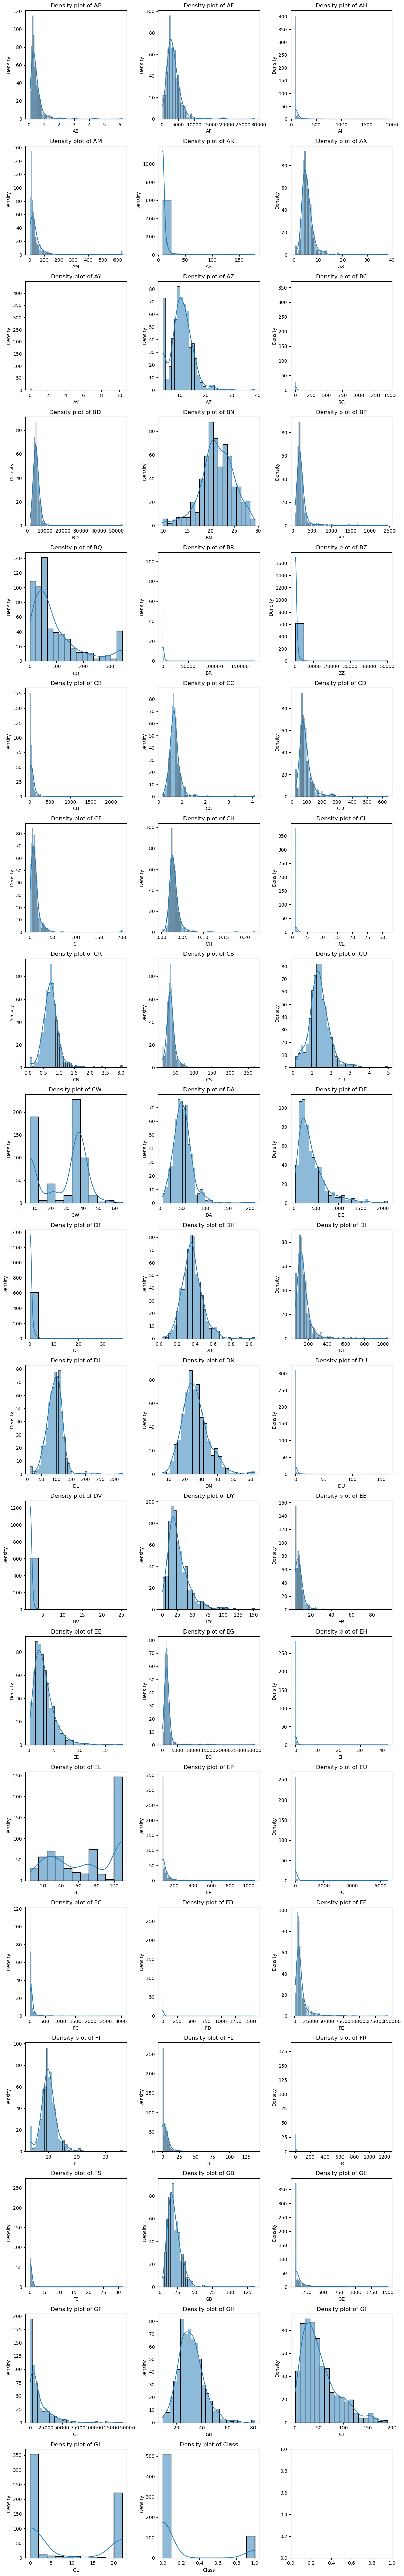

In [16]:
numerical_columns = merged_train_csv.select_dtypes(exclude='object').columns
num_plots = len(numerical_columns)
num_rows = (num_plots - 1) // 3 + 1  # Adjust the number of rows as needed

fig, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows*4))  # Adjust the figure size as needed

for i, column in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(merged_train_csv[column], kde=True, ax=ax)
    ax.set_title(f'Density plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

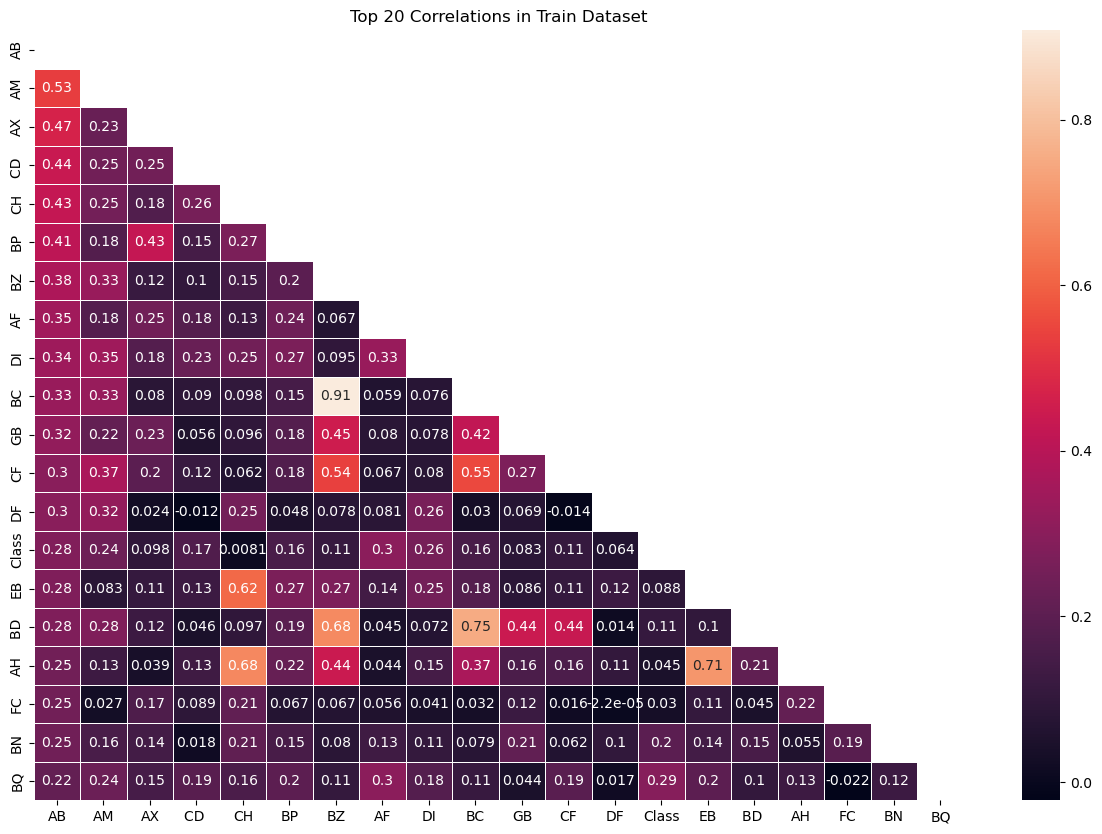

In [17]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(15, 10))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(merged_train_csv[numerical_columns], 20, 'Top 20 Correlations in Train Dataset')

## Modeling

In [18]:
label_encoder = LabelEncoder()
train_csv['EJ'] = label_encoder.fit_transform(train_csv['EJ'])
test_csv['EJ'] = label_encoder.fit_transform(test_csv['EJ'])
merged_train_csv['EJ'] = label_encoder.fit_transform(merged_train_csv['EJ'])
merged_train_csv['Alpha'] = label_encoder.fit_transform(merged_train_csv['Alpha'])
merged_train_csv['Beta'] = label_encoder.fit_transform(merged_train_csv['Beta'])
merged_train_csv['Gamma'] = label_encoder.fit_transform(merged_train_csv['Gamma'])
merged_train_csv['Delta'] = label_encoder.fit_transform(merged_train_csv['Delta'])
merged_train_csv['Epsilon'] = label_encoder.fit_transform(merged_train_csv['Epsilon'])

In [19]:
master_features = ['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha',
       'Beta', 'Gamma', 'Delta', 'Epsilon']

In [20]:
features = ['Beta', 'Gamma', 'Delta']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Class'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_delta = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_delta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_delta.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_delta.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/50


2023-05-27 03:06:28.993128: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 2s 89ms/step - loss: 0.6585 - accuracy: 0.7234 - val_loss: 0.7161 - val_accuracy: 0.9394
Epoch 2/50
7/7 [==============================] - 0s 26ms/step - loss: 0.4197 - accuracy: 0.8985 - val_loss: 0.6522 - val_accuracy: 0.9192
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 0.2981 - accuracy: 0.9822 - val_loss: 0.6027 - val_accuracy: 0.9192
Epoch 4/50
7/7 [==============================] - 0s 38ms/step - loss: 0.2441 - accuracy: 0.9924 - val_loss: 0.5594 - val_accuracy: 0.9192
Epoch 5/50
7/7 [==============================] - 0s 33ms/step - loss: 0.2144 - accuracy: 0.9949 - val_loss: 0.5233 - val_accuracy: 0.9394
Epoch 6/50
7/7 [==============================] - 0s 31ms/step - loss: 0.2037 - accuracy: 0.9898 - val_loss: 0.4925 - val_accuracy: 0.9394
Epoch 7/50
7/7 [==============================] - 0s 32ms/step - loss: 0.1775 - accuracy: 0.9949 - val_loss: 0.4633 - val_accuracy: 0.9394
Epoch 8/50
7/7 [======================

In [21]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class']

X_train, X_test, y_train, y_test = train_test_split(train_csv[features],train_csv['Class'],test_size=0.2,random_state=1000)
print(f'X_train shape: {X_train.shape}')
print('Train LGBM classifier ...')
clf = LGBMClassifier(n_estimators=100,
                     num_leaves=64,
                     max_depth=5,
                     learning_rate=0.1,
                     random_state=1000,
                     n_jobs=-1)
start = time.time()
clf.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed} seconds')
y_pred = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)}')

print('Train XGB classifier ...')
clf = XGBClassifier(n_estimators=100,
                     max_depth=5,
                     max_leaves=64,
                     eta=0.1,
                     reg_lambda=0,
                     tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=1000,
                     n_jobs=-1)
start = time.time()
clf.fit(X_train,y_train)
elapsed = time.time() - start
print(f'XGB Training ran in {elapsed} seconds')
y_pred = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)}')

X_train shape: (493, 57)
Train LGBM classifier ...
LGBM Training ran in 0.08982300758361816 seconds
Test Accuracy: 1.0
Train XGB classifier ...
XGB Training ran in 0.05925393104553223 seconds
Test Accuracy: 1.0


/Users/subhash/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [22]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Beta', 'Gamma', 
       'Delta', 'Epsilon']

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Alpha'],test_size=0.2,random_state=1000)
print(f'X_train shape: {X_train.shape}')
print('Train LGBM classifier ...')
clf = LGBMClassifier(n_estimators=100,
                     num_leaves=64,
                     max_depth=5,
                     learning_rate=0.1,
                     random_state=1000,
                     n_jobs=-1)
start = time.time()
clf.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed} seconds')
y_pred = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)}')
print('Train XGB classifier ...')
clf = XGBClassifier(n_estimators=100,
                     max_depth=5,
                     max_leaves=64,
                     eta=0.1,
                     reg_lambda=0,
                     tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=1000,
                     n_jobs=-1)
start = time.time()
clf.fit(X_train,y_train)
elapsed = time.time() - start
print(f'XGB Training ran in {elapsed} seconds')
y_pred = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)}')

X_train shape: (493, 60)
Train LGBM classifier ...
LGBM Training ran in 0.3799107074737549 seconds
Test Accuracy: 1.0
Train XGB classifier ...
XGB Training ran in 0.15715527534484863 seconds
Test Accuracy: 1.0


/Users/subhash/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [23]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(train_csv[features],train_csv['Class'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_labels)

# Calculate log loss
logloss = log_loss(y_test, y_pred)

# Calculate balanced log loss
balanced_log_loss = logloss / np.log(4)

print('Balanced Log Loss:', balanced_log_loss)

Epoch 1/50
7/7 [==============================] - 1s 80ms/step - loss: 0.9012 - accuracy: 0.6066 - val_loss: 0.8247 - val_accuracy: 0.5051
Epoch 2/50
7/7 [==============================] - 0s 25ms/step - loss: 0.7103 - accuracy: 0.7310 - val_loss: 0.7483 - val_accuracy: 0.7071
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.6534 - accuracy: 0.8046 - val_loss: 0.6830 - val_accuracy: 0.8182
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 0.5721 - accuracy: 0.8173 - val_loss: 0.6444 - val_accuracy: 0.8687
Epoch 5/50
7/7 [==============================] - 0s 22ms/step - loss: 0.5423 - accuracy: 0.8350 - val_loss: 0.6238 - val_accuracy: 0.8687
Epoch 6/50
7/7 [==============================] - 0s 23ms/step - loss: 0.5086 - accuracy: 0.8604 - val_loss: 0.6005 - val_accuracy: 0.8788
Epoch 7/50
7/7 [==============================] - 0s 24ms/step - loss: 0.4679 - accuracy: 0.8731 - val_loss: 0.5643 - val_accuracy: 0.8788
Epoch 8/50
7/7 [===========

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               7296      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                

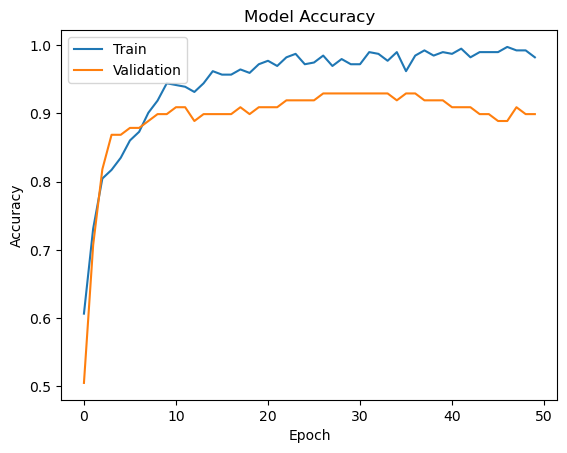

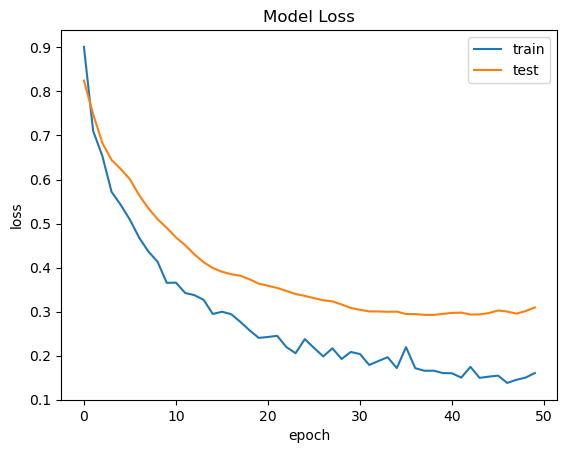

In [24]:
print(model.summary())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [25]:
categorical_pred = np.argmax(model.predict(X_test), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

4/4 [==============================] - 0s 11ms/step
Results for Categorical Model
0.8064516129032258
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       100
           1       0.00      0.00      0.00        24

    accuracy                           0.81       124
   macro avg       0.40      0.50      0.45       124
weighted avg       0.65      0.81      0.72       124



/Users/subhash/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/subhash/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/subhash/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [26]:
test_csv_scaled = scaler.transform(test_csv[features])
y_pred = model.predict(test_csv[features])
my_submission = test_csv.copy()
my_submission = my_submission[['Id']]
my_submission['class_0'] = 1 - y_pred
my_submission['class_1'] = y_pred

my_submission.to_csv('submission_pre_nn.csv', index=False)

1/1 [==============================] - 0s 37ms/step


In [27]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Beta'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_beta = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_beta.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_beta.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_beta.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/50
7/7 [==============================] - 1s 86ms/step - loss: 1.5940 - accuracy: 0.3655 - val_loss: 1.2326 - val_accuracy: 0.4141
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 1.1522 - accuracy: 0.5558 - val_loss: 1.1666 - val_accuracy: 0.5556
Epoch 3/50
7/7 [==============================] - 0s 27ms/step - loss: 1.0253 - accuracy: 0.6041 - val_loss: 1.1119 - val_accuracy: 0.5960
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.9332 - accuracy: 0.6599 - val_loss: 1.0520 - val_accuracy: 0.6465
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 0.8387 - accuracy: 0.7132 - val_loss: 0.9955 - val_accuracy: 0.7071
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 0.7612 - accuracy: 0.7462 - val_loss: 0.9483 - val_accuracy: 0.7576
Epoch 7/50
7/7 [==============================] - 0s 31ms/step - loss: 0.6855 - accuracy: 0.7995 - val_loss: 0.8999 - val_accuracy: 0.7576
Epoch 8/50
7/7 [===========

In [28]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_train_csv[features])
y_pred_beta = np.argmax(model_beta.predict(scaled_df), axis=1)
first_output = pd.DataFrame({'beta': y_pred_beta})
first_output

20/20 [==============================] - 0s 6ms/step


,beta
0,2
1,2
2,2
3,2
4,1
...,...
612,1
613,1
614,2
615,2


In [29]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Gamma'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_gamma = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_gamma.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_gamma.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_gamma.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/50
7/7 [==============================] - 1s 89ms/step - loss: 2.7184 - accuracy: 0.1777 - val_loss: 2.0783 - val_accuracy: 0.3636
Epoch 2/50
7/7 [==============================] - 0s 36ms/step - loss: 2.2193 - accuracy: 0.2944 - val_loss: 2.0421 - val_accuracy: 0.4444
Epoch 3/50
7/7 [==============================] - 0s 35ms/step - loss: 1.8934 - accuracy: 0.4416 - val_loss: 1.9580 - val_accuracy: 0.5758
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 1.7630 - accuracy: 0.5203 - val_loss: 1.8798 - val_accuracy: 0.6364
Epoch 5/50
7/7 [==============================] - 0s 25ms/step - loss: 1.6217 - accuracy: 0.5711 - val_loss: 1.7859 - val_accuracy: 0.6667
Epoch 6/50
7/7 [==============================] - 0s 47ms/step - loss: 1.4607 - accuracy: 0.6193 - val_loss: 1.6982 - val_accuracy: 0.6970
Epoch 7/50
7/7 [==============================] - 0s 37ms/step - loss: 1.3598 - accuracy: 0.6827 - val_loss: 1.6011 - val_accuracy: 0.6970
Epoch 8/50
7/7 [===========

In [30]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_train_csv[features])
y_pred_gamma = np.argmax(model_gamma.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'gamma': y_pred_gamma})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

20/20 [==============================] - 0s 6ms/step


,beta,gamma
0,2,4
1,2,6
2,2,6
3,2,6
4,1,3
...,...,...
612,1,6
613,1,6
614,2,6
615,2,6


In [31]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Delta'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_delta = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_delta.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_delta.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_delta.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/50
7/7 [==============================] - 1s 92ms/step - loss: 1.9513 - accuracy: 0.2893 - val_loss: 1.8710 - val_accuracy: 0.1212
Epoch 2/50
7/7 [==============================] - 0s 34ms/step - loss: 1.6540 - accuracy: 0.3858 - val_loss: 1.6558 - val_accuracy: 0.2828
Epoch 3/50
7/7 [==============================] - 0s 27ms/step - loss: 1.3891 - accuracy: 0.4670 - val_loss: 1.4974 - val_accuracy: 0.4545
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 1.2703 - accuracy: 0.5178 - val_loss: 1.3703 - val_accuracy: 0.5657
Epoch 5/50
7/7 [==============================] - 0s 28ms/step - loss: 1.1523 - accuracy: 0.6041 - val_loss: 1.2737 - val_accuracy: 0.6364
Epoch 6/50
7/7 [==============================] - 0s 32ms/step - loss: 1.0979 - accuracy: 0.6396 - val_loss: 1.2056 - val_accuracy: 0.7172
Epoch 7/50
7/7 [==============================] - 0s 34ms/step - loss: 0.9992 - accuracy: 0.6751 - val_loss: 1.1404 - val_accuracy: 0.7273
Epoch 8/50
7/7 [===========

In [32]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_train_csv[features])
y_pred_delta = np.argmax(model_delta.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'delta': y_pred_delta})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

20/20 [==============================] - 0s 6ms/step


,beta,gamma,delta
0,2,4,3
1,2,6,1
2,2,6,1
3,2,6,1
4,1,3,1
...,...,...,...
612,1,6,1
613,1,6,1
614,2,6,1
615,2,6,1


In [33]:
features = ['delta', 'beta', 'gamma']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(first_output[features],merged_train_csv['Class'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_class = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_class.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_class.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/50
7/7 [==============================] - 2s 145ms/step - loss: 0.7570 - accuracy: 0.6548 - val_loss: 0.7441 - val_accuracy: 0.9091
Epoch 2/50
7/7 [==============================] - 0s 32ms/step - loss: 0.4432 - accuracy: 0.8959 - val_loss: 0.6917 - val_accuracy: 0.8889
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 0.3522 - accuracy: 0.9569 - val_loss: 0.6521 - val_accuracy: 0.8788
Epoch 4/50
7/7 [==============================] - 0s 36ms/step - loss: 0.2810 - accuracy: 0.9721 - val_loss: 0.6184 - val_accuracy: 0.8788
Epoch 5/50
7/7 [==============================] - 0s 39ms/step - loss: 0.2403 - accuracy: 0.9898 - val_loss: 0.5845 - val_accuracy: 0.8788
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 0.2366 - accuracy: 0.9822 - val_loss: 0.5565 - val_accuracy: 0.8788
Epoch 7/50
7/7 [==============================] - 0s 29ms/step - loss: 0.2044 - accuracy: 0.9924 - val_loss: 0.5374 - val_accuracy: 0.8788
Epoch 8/50
7/7 [==========

In [34]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(first_output[features])

y_pred = model_class.predict(scaled_df)
y_pred

20/20 [==============================] - 0s 7ms/step


array([[9.9956459e-01],
       [9.8236948e-03],
       [9.8236948e-03],
       [9.8236948e-03],
       [9.9996793e-01],
       [9.8236948e-03],
       [9.8236948e-03],
       [4.5844298e-03],
       [9.8236948e-03],
       [9.8236948e-03],
       [1.7548416e-02],
       [4.5844298e-03],
       [4.5844298e-03],
       [9.9999952e-01],
       [1.8866824e-02],
       [9.8236948e-03],
       [1.7548416e-02],
       [4.5844298e-03],
       [9.8236948e-03],
       [9.8236948e-03],
       [9.8236948e-03],
       [4.5844298e-03],
       [6.6058293e-02],
       [9.8236948e-03],
       [9.8236948e-03],
       [6.6058293e-02],
       [4.5844298e-03],
       [9.8236948e-03],
       [6.6058293e-02],
       [4.5844298e-03],
       [9.8236948e-03],
       [9.9999964e-01],
       [9.5514363e-01],
       [6.6058293e-02],
       [4.0341940e-02],
       [9.8236948e-03],
       [9.5514363e-01],
       [9.8236948e-03],
       [9.8236948e-03],
       [6.6058293e-02],
       [9.8236948e-03],
       [1.000000

In [35]:
# Add columns with zeroes
num_columns = 4  # Number of columns to add
zero_columns = ['Beta', 'Gamma', 'Delta', 'Epsilon']  # Column names for zero columns
merged_test_csv = test_csv.assign(**{col: 0 for col in zero_columns[:num_columns]})
merged_test_csv

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Beta,Gamma,Delta,Epsilon
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [36]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_test_csv[features])
y_pred_beta = np.argmax(model_beta.predict(scaled_df), axis=1)
first_output = pd.DataFrame({'beta': y_pred_beta})
first_output

1/1 [==============================] - 0s 46ms/step


,beta
0,2
1,2
2,2
3,2
4,2


In [37]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_test_csv[features])
y_pred_gamma = np.argmax(model_gamma.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'gamma': y_pred_gamma})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

1/1 [==============================] - 0s 52ms/step


,beta,gamma
0,2,6
1,2,6
2,2,6
3,2,6
4,2,6


In [38]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_test_csv[features])
y_pred_delta = np.argmax(model_delta.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'delta': y_pred_delta})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

1/1 [==============================] - 0s 56ms/step


,beta,gamma,delta
0,2,6,1
1,2,6,1
2,2,6,1
3,2,6,1
4,2,6,1


In [39]:
features = ['delta', 'beta', 'gamma']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(first_output[features])

y_pred = model_class.predict(scaled_df)
y_pred

1/1 [==============================] - 0s 56ms/step


array([[0.10751836],
       [0.10751836],
       [0.10751836],
       [0.10751836],
       [0.10751836]], dtype=float32)

In [ ]:
my_submission = test_csv.copy()
my_submission = my_submission[['Id']]
my_submission['class_0'] = 1 - y_pred
my_submission['class_1'] = y_pred

my_submission.to_csv('submission_nn.csv', index=False)